In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sys.path.append("/homes/lexjohan/Documents/EME/SVDD/")
sys.path.append('/homes/lexjohan/Documents/models')
os.path.join("nxsdk_modules_ncl/snntoolbox")


# Enable SLURM to run network on Loihi.
os.environ['SLURM'] = '1'
os.environ['PYTHONUNBUFFERED'] = '1'

os.environ["PARTITION"] = "nahuku32_2h"
os.environ["BOARD"] = 'ncl-ext-ghrd-01'

snipDir = os.path.abspath(os.path.join('..', 'snips', 'reset_model_states'))


In [3]:
batch_size = 32
num_training_epochs = 2
input_shape = (28, 28, 1)

# set later
#num_steps_per_img = 75
num_train_samples = 60000
num_test_samples = 128

# EnergyProbes allow to profile execution time, power and thus energy consumption
enable_energy_probe = True
# set later
#execution_time_probe_bin_size = 75 # Small numbers slows down execution

# Not yet supported
measure_accuracy_runtime_trade_off = False # Not yet supported
runtimes = [128, 256, 512, 1024, 2048]

In [4]:
from keras.datasets import mnist
from keras.utils import np_utils

# Load standard MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize input so we can train ANN with it. 
# Will be converted back to integers for SNN layer.
x_train = x_train[:num_train_samples, :, :] / 255
x_test = x_test / 255

# Add a channel dimension.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode target vectors.
y_train = np_utils.to_categorical(y_train[:num_train_samples], 10)
y_test = np_utils.to_categorical(y_test, 10)

2023-01-25 06:48:38.878975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 06:48:39.016506: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /slurm/intel-archi/lib
2023-01-25 06:48:39.016543: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-25 06:48:39.843286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared obj

In [5]:
def runModel(num_steps_per_sample, x_test, y_test):
    """Runs the SNN Model to classify test images."""
      
    # Initialize arrays for results
    num_samples = len(y_test)
    classifications = np.zeros(num_samples, int)
    labels = np.zeros(num_samples, int)

    # Run DNN to classify images
    tStart = time.time()
    snn_model.run(num_steps_per_sample * num_samples, aSync=True)
    tEndBoot = time.time()

    # Enqueue images by pushing them into InputGenerator
    print("Queuing images...")
    for i, (x, y) in enumerate(zip((x_test* 255).astype(int), y_test)):
        input_generator.encode(x)
        labels[i] = np.argmax(y)
    tEndInput = time.time()

    # Read out classification results for all images
    print("Waiting for classification to finish...")
    classifications = list(dnn.readout_channel.read(num_samples))
    tEndClassification = time.time()
    
    # finishRun fetches EnergyProbe data if configured
    snn_model.finishRun()
    
    return tStart, tEndBoot, tEndInput, tEndClassification, classifications, labels

def calcAccuracy(classifications, labels):
    """Computes classification accuracy for a set of images given classification and labels."""
    errors = classifications != labels
    num_errors = np.sum(errors)
    num_samples = len(classifications)
    return (num_samples-num_errors)/num_samples

In [6]:
def plot_samples(samples, guesses, lables, numCols=5, size=28):
    """Plots samples as an array of images."""
    
    import math
    numSamples = len(samples)
    numRows = int(math.ceil(numSamples/numCols))
    plt.figure(3, figsize=(20, 10))
    i = 0
    for c in range(numCols):
        for r in range(numRows):
            plt.subplot(numRows, numCols, i+1)
            plt.imshow(np.reshape(samples[i,:], (size, size)))
            plt.axis('off')
            plt.title('C:{}/L:{}'.format(guesses[i], lables[i]))
            i += 1
            if i == numSamples:
                break
        if i == numSamples:
            break
    plt.show()

In [7]:
import os
import keras
#from keras.models import Model
from keras.layers import Dropout, Flatten, Conv2D, Input, Dense


from nxsdk_modules_ncl.dnn.src.utils import extract
from nxsdk_modules_ncl.dnn.src.dnn_layers import NxInputLayer, NxConv2D, NxDense, \
    NxModel, NxFlatten, ProbableStates

from nxsdk_modules_ncl.dnn.src.optimization import ExclusionCriteria
from nxsdk_modules_ncl.dnn.composable.composable_dnn import ComposableDNN

from nxsdk_modules_ncl.dnn.src.utils import to_integer

from nxsdk_modules_ncl.dnn.composable.composable_dnn import ComposableDNN as DNN
from nxsdk_modules_ncl.input_generator.input_generator import InputGenerator

from nxsdk.composable.model import Model
from nxsdk.logutils.nxlogging import set_verbosity,LoggingLevel
import csv
#from nxsdk.api.n2a as 
set_verbosity(LoggingLevel.ERROR)

In [8]:
#import csv
#
#with open('t_acc_e_conv.csv', 'w') as csvfile:
#    writer = csv.writer(csvfile)
#    writer.writerows(vals_conv)

In [8]:
## timing ANN
from timeit import default_timer as timer
from network import LIFNetwork
from utils import poisson_gen
from grad_functions import surrogate_fn, ba_fn
import tensorflow as tf

os.environ['']

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_test_begin(self, logs={}):
        self.starttime = timer()
    def on_test_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

train_model = True
     
## Array for time
## Array for accuracy
## Array for Energy
vals_dense = np.zeros((5, 5, 10))
    
    
# Path for pre-trained model
pretrained_model_path = os.path.join(os.path.abspath(''),
                                     'models', 
                                     'a_minist_model.h5')

layer_sizes = [10, 40, 100, 400, 1000]
step_sizes = [30, 50, 100]
#layer_sizes = [10]
#step_sizes = [10]

ann_time = np.zeros((len(layer_sizes), 10))
accuracy_ANN = np.zeros((len(layer_sizes), 10))
vals_dense = np.zeros((5, len(layer_sizes), len(step_sizes), 10))

mean_vals_t1 = np.zeros((len(layer_sizes), len(step_sizes)))
std_vals_t1 = np.zeros((len(layer_sizes), len(step_sizes)))
mean_vals_t2 = np.zeros((len(layer_sizes), len(step_sizes)))
std_vals_t2 = np.zeros((len(layer_sizes), len(step_sizes)))
mean_vals_acc = np.zeros((len(layer_sizes), len(step_sizes)))
std_vals_acc = np.zeros((len(layer_sizes), len(step_sizes)))
mean_vals_e1 = np.zeros((len(layer_sizes), len(step_sizes)))
std_vals_e1 = np.zeros((len(layer_sizes), len(step_sizes)))
mean_vals_e2 = np.zeros((len(layer_sizes), len(step_sizes)))
std_vals_e2 = np.zeros((len(layer_sizes), len(step_sizes)))


n_dim = 10
    
# Generate model
for k in range(len(step_sizes)):
    print(f"Number of time steps: {step_sizes[k]}")
    num_steps_per_img = step_sizes[k]
    execution_time_probe_bin_size = step_sizes[k]
    for i in range(len(layer_sizes)):
        print(f"Neurons in hidden layer: {layer_sizes[i]}")
        for j in range(10):
            model_path = f"models/weights-ba/weights-time_step{step_sizes[k]}-layer_size{layer_sizes[i]}-n{j}-surrogate"
            # "weights-time_step30-layer_size10-n0-ba"

            # ann_model = keras.models.load_model(model_path)
            # ann_model.summary()
            # for x in ann_model.get_weights():
            #     print(x.shape)

            # ann_model.summary()

            ann_model = LIFNetwork([layer_sizes[i], 10],
                                   nt = step_sizes[k], burn_in=20, grad_fn_name=surrogate_fn, surrogate_fn=surrogate_fn, gen=poisson_gen,
                                   dtype=tf.float32)
            ann_model.compile(optimizer='adam', metrics=['mse', 'accuracy'], run_eagerly=True)
            ann_model(tf.convert_to_tensor(x_train[:1].reshape(-1, 784), dtype=tf.float32))
            ann_model.load_weights(model_path)

            vth_mant = 2**9
            bias_exp = 6
            weight_exponent = 0
            synapse_encoding = 'sparse'
            #exclusionCriteria = ExclusionCriteria()

            inputLayer = NxInputLayer((28,28), 
                                         vThMant=vth_mant, 
                                         biasExp=bias_exp)

            input_layer = NxFlatten()(inputLayer.input)

            layer = NxDense(layer_sizes[i], activation='relu')(input_layer)

            outputs = NxDense(10, activation='softmax')(layer)

            snn_nxmodel = NxModel(inputLayer.input, outputs, numCandidatesToCompute=1)

            # Extract weights and biases from parameter list.
            parameters = ann_model.get_weights()
            weights = parameters[0::2]
            biases = parameters[1::2]

            # Quantize weights and biases using max-normalization (Strong quantization loss if distributions have large tails)
            parameters_int = []
            for w, b in zip(weights, biases):
                w_int, b_int = to_integer(w, b, 8)
                parameters_int += [w_int, b_int]

            # Set quantized weigths and biases for spiking model
            snn_nxmodel.set_weights(parameters_int)


            # NxModel is not yet implemented as a Composable -> Wrap it with DNN composable class
            dnn = DNN(model=snn_nxmodel, num_steps_per_img=num_steps_per_img)

            input_generator = InputGenerator(shape=(28,28), interval=num_steps_per_img)

            input_generator.setBiasExp(bias_exp)


            #set_verbosity(LoggingLevel.ERROR)

            # Initialize empty model
            snn_model = Model("dnn_model")

            # Add DNN and InputGenerator to empty model
            snn_model.add(dnn)
            snn_model.add(input_generator)


            # Connect InputGenerator to DNN
            # (Explicit)
            # input_generator.ports.output.connect(dnn.ports.input)
            # (Implicit when ports can be inferred)
            input_generator.connect(dnn)

            # Enfore particular execution order or processes/snips executing in the same phase
            # (Here: Execute input injection as bias currents after network reset)
            input_generator.processes.inputEncoder.executeAfter(dnn.processes.reset)

            snn_model.compile()

            if enable_energy_probe:
                from nxsdk.api.enums.api_enums import ProbeParameter
                from nxsdk.graph.monitor.probes import PerformanceProbeCondition
                eProbe = snn_model.board.probe(probeType=ProbeParameter.ENERGY, 
                                               probeCondition=PerformanceProbeCondition(
                                                    tStart=1, 
                                                    tEnd=num_test_samples*num_steps_per_img, 
                                                    bufferSize=1024, 
                                                    binSize=execution_time_probe_bin_size))

            snn_model.start(snn_nxmodel.board)

            tStart, tEndBoot, tEndInput, tEndClassification, classifications, labels = runModel(num_steps_per_img, 
                                                                                                x_test[:num_test_samples, :, :, 0], 
                                                                                                y_test[:num_test_samples])

             # Runtime statistics
            runtimeBoot = tEndBoot-tStart
            runtimeInput = tEndInput-tStart
            runtimeClassification = tEndClassification-tStart

            vals_dense[0, i, k, j] = runtimeClassification-runtimeInput
            vals_dense[3, i, k, j] = np.mean(eProbe.spikingTimePerTimeStep)*num_steps_per_img/1e3

            # Accuracy statistics
            errors = classifications != labels
            num_errors = np.sum(errors)

            vals_dense[1, i, k, j] = (num_test_samples-num_errors)/num_test_samples


            vals_dense[2, i, k, j] = eProbe.totalEnergy
            vals_dense[4, i, k, j] = np.mean(eProbe.totalEnergyPerTimeStep)*num_steps_per_img

            if not measure_accuracy_runtime_trade_off:
                snn_model.disconnect()

    mean_vals_t1[:, k] = np.mean(vals_dense[0, :, k, :], 1)
    std_vals_t1[:, k] = np.std(vals_dense[0, :, k, :], 1)

    mean_vals_t2[:, k] = np.mean(vals_dense[3, :, k, :], 1)
    std_vals_t2[:, k] = np.std(vals_dense[3, :, k, :], 1)

    mean_vals_acc[:, k] = np.mean(vals_dense[1, :, k, :], 1)
    std_vals_acc[:, k] = np.std(vals_dense[1, :, k, :], 1)

    mean_vals_e1[:, k] = np.mean(vals_dense[2, :, k, :], 1)
    std_vals_e1[:, k] = np.std(vals_dense[2, :, k, :], 1)

    mean_vals_e2[:, k] = np.mean(vals_dense[4, :, k, :], 1)
    std_vals_e2[:, k] = np.std(vals_dense[4, :, k, :], 1)

total_list = [mean_vals_t1, std_vals_t1, mean_vals_t2, std_vals_t2, mean_vals_acc, 
              std_vals_acc, mean_vals_e1, std_vals_e1, mean_vals_e2, std_vals_e2]
csv_names = ["mean_vals_t1_copi_surrogate.csv", "std_vals_t1_copi_surrogate.csv", "mean_vals_t2_copi_surrogate.csv", 'std_vals_t2_copi_surrogate.csv', 'mean_vals_acc_copi_surrogate.csv'
            'std_vals_acc_copi_surrogate.csv', 'mean_vals_e1_copi_surrogate.csv', 'std_vals_e1_copi_surrogate.csv', 'mean_vals_e2_copi_surrogate.csv', 'std_vals_e2_copi_surrogate.csv']
for i in range(len(csv_names)):
    with open(csv_names[i], mode='w') as employee_file:
        employee_writer = csv.writer(employee_file, delimiter=',',  quotechar='"', 
                                     quoting=csv.QUOTE_MINIMAL)
        employee_writer.writerow(total_list[i])

Number of time steps: 30
Neurons in hidden layer: 10
x



2023-01-22 17:30:37.437299: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /slurm/intel-archi/lib
2023-01-22 17:30:37.437592: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-22 17:30:37.437610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ncl-edu): /proc/driver/nvidia/version does not exist
2023-01-22 17:30:37.437834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
Neurons in hidden layer: 40. 
x

x

x

x

Queuing images...spikes... . .. 
Waiting for classification to finish...
x

x

x

x

Queuing images...spikes...

In [1]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    plt.errorbar(layer_sizes, mean_vals_t1[:, i], yerr = std_vals_t1[:, i],
                 label = f"step_sizes = {step_sizes[i]}")
    plt.ylabel("time [s]")
    plt.xlabel("Layers")
    plt.title("Total Time over hidden layers, copi-ba")
    plt.xscale('log')
    plt.legend()
    

fig.savefig('total_time_dense_layer_stepsize_copi_ba.jpg', bbox_inches='tight', dpi=150)

plt.show()

NameError: name 'plt' is not defined

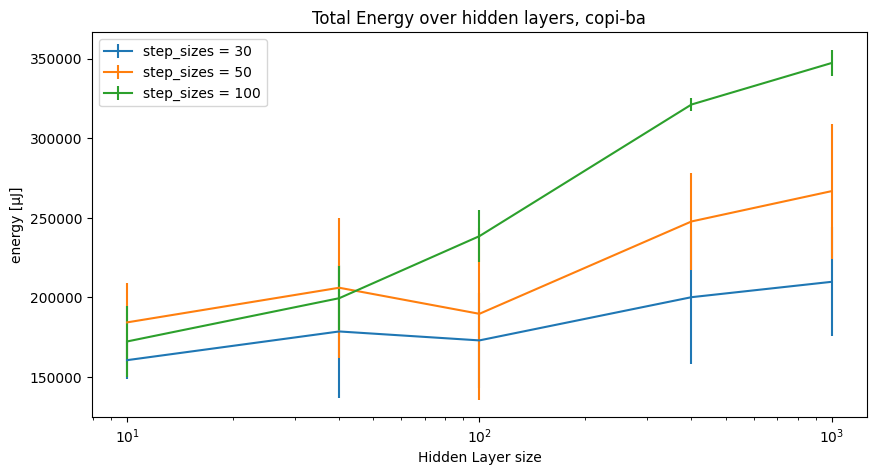

In [16]:
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    plt.errorbar(layer_sizes, mean_vals_e1[:, i], yerr = std_vals_e1[:, i],
                label = f"step_sizes = {step_sizes[i]}")
    plt.xlabel("Hidden Layer size")
    plt.ylabel("energy [µJ]")
    plt.title("Total Energy over hidden layers, copi-ba")
    plt.xscale('log')
    plt.legend()
    
fig.savefig('total_energy_dense_layer_stepsize_copi_ba.jpg', bbox_inches='tight', dpi=150)

plt.show()

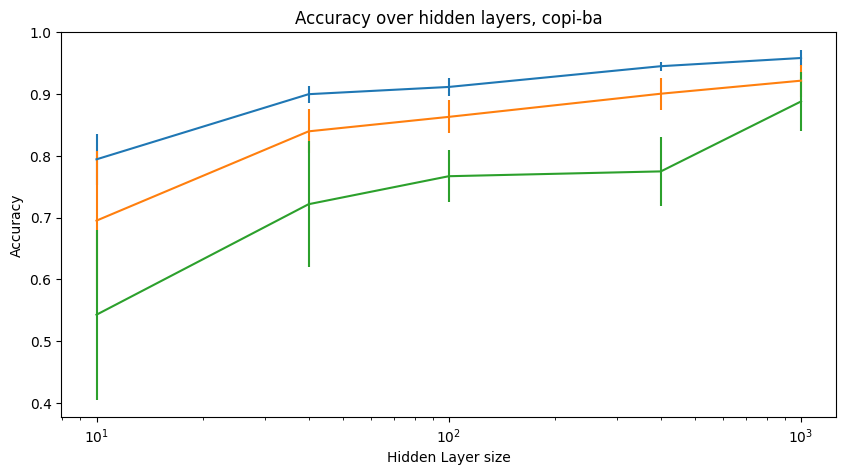

In [17]:
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    plt.errorbar(layer_sizes, mean_vals_acc[:, i], yerr = std_vals_acc[:, i],
                label = f"step_sizes = {step_sizes[i]}")
    plt.ylabel("Accuracy")
    plt.xlabel("Hidden Layer size")
    plt.title("Accuracy over hidden layers, copi-ba")
    plt.xscale('log')

fig.savefig('accuracy_dense_layer_stepsize_copi_ba.jpg', bbox_inches='tight', dpi=150)
plt.show()

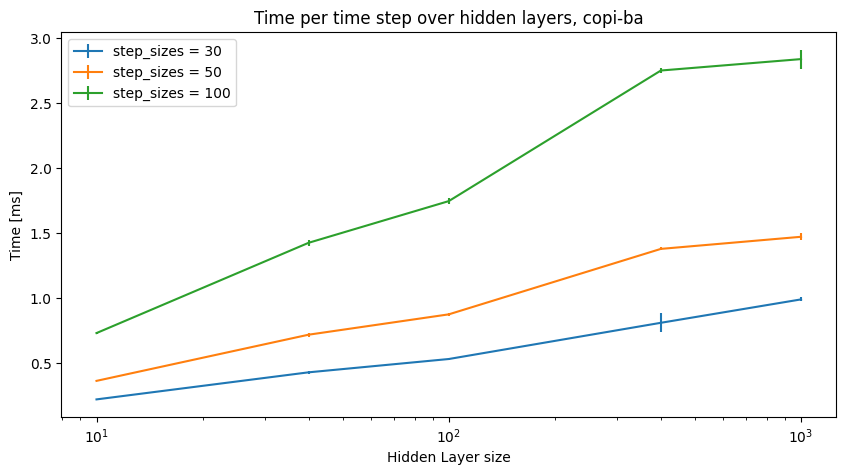

In [18]:
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    plt.errorbar(layer_sizes, mean_vals_t2[:, i], yerr = std_vals_t2[:, i],
                 label = f"step_sizes = {step_sizes[i]}")
    plt.xlabel("Hidden Layer size")
    plt.ylabel("Time [ms]")
    plt.title("Time per time step over hidden layers, copi-ba")
    plt.xscale('log')
    plt.legend()
    

fig.savefig('time_timestep_av_dense_layer_stepsize_copi_ba.jpg', bbox_inches='tight', dpi=150)

plt.show()

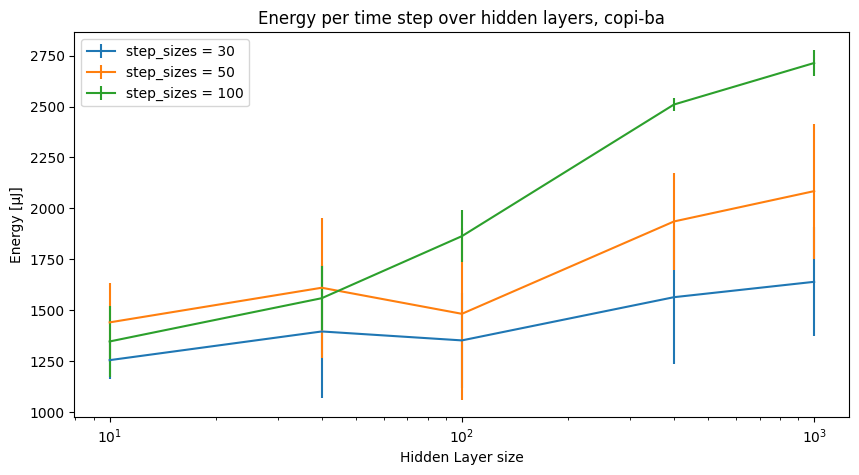

In [19]:
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    plt.errorbar(layer_sizes, mean_vals_e2[:, i], yerr = std_vals_e2[:, i],
                label = f"step_sizes = {step_sizes[i]}")
    plt.xlabel("Hidden Layer size")
    plt.ylabel("Energy [µJ]")
    plt.title("Energy per time step over hidden layers, copi-ba")
    plt.xscale('log')
    plt.legend()
    
fig.savefig('energy_timestep_av_dense_layer_stepsize.jpg_copi_ba.jpg', bbox_inches='tight', dpi=150)

plt.show()

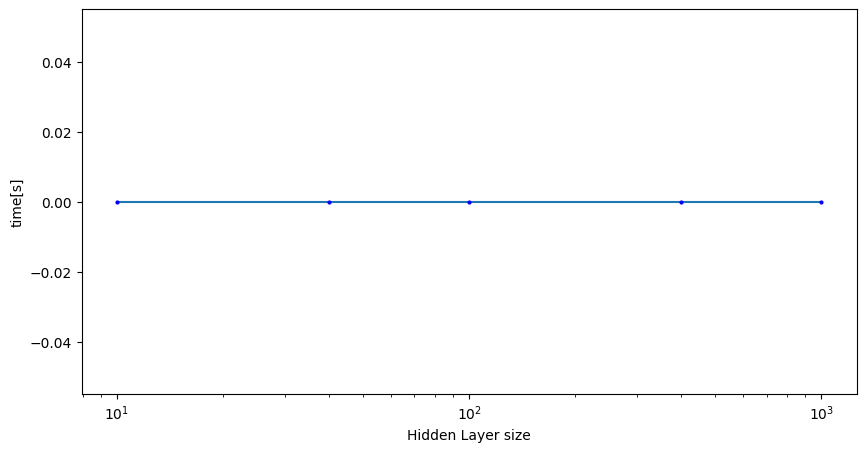

In [21]:
mean_time_ann = np.mean(ann_time, axis = 1)
sd_time_ann = np.std(ann_time, axis = 1)

mean_acc_ann = np.mean(accuracy_ANN, axis = 1)
sd_acc_ann = np.std(accuracy_ANN, axis = 1)

fig = plt.figure(figsize=(10,5))

plt.plot(layer_sizes, mean_time_ann)
plt.errorbar(layer_sizes, mean_time_ann, yerr = sd_time_ann, fmt ='o', mfc = 'b', mec = 'b', ms = 2)
plt.ylabel("time[s]")
plt.xlabel("Hidden Layer size")
plt.xscale('log')

fig.savefig('ANN_time_dense.jpg_copi_ba.jpg', bbox_inches='tight', dpi=150)
plt.show()

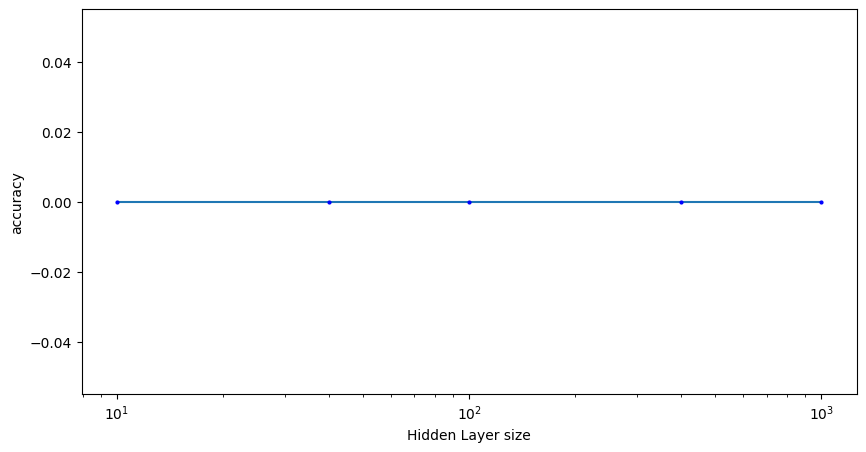

In [22]:
fig = plt.figure(figsize=(10,5))

plt.plot(layer_sizes, mean_acc_ann)
plt.errorbar(layer_sizes, mean_acc_ann, yerr = sd_acc_ann, fmt ='o', mfc = 'b', mec = 'b', ms = 2)
plt.ylabel("accuracy")
plt.xlabel("Hidden Layer size")
plt.xscale('log')

fig.savefig('ANN_acc_dense.jpg_copi_ba.jpg', bbox_inches='tight', dpi=150)
plt.show()

In [23]:
## Throughput values 
through_time = 1/(mean_vals_t1/num_test_samples)
through_time_sd = 1/(std_vals_t1/(num_test_samples)**2)

through_energy = (mean_vals_e1/num_test_samples)
through_energy_sd = 1/(std_vals_e1/(num_test_samples)**2)

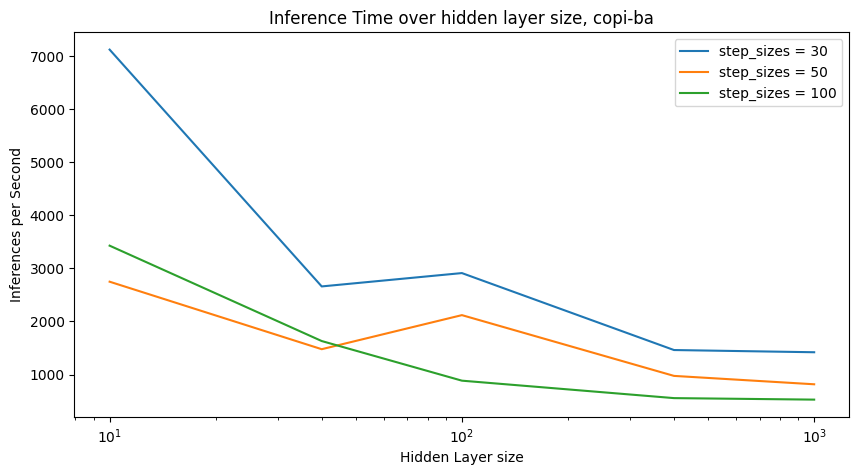

In [26]:
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    # plt.errorbar(layer_sizes, through_time[:, i], yerr = through_time_sd[:, i],
    #              label = f"step_sizes = {step_sizes[i]}")
    plt.plot(layer_sizes, through_time[:, i], label=f"step_sizes = {step_sizes[i]}")
    plt.xlabel("Hidden Layer size")
    plt.ylabel("Inferences per Second")
    plt.title("Inference Time over hidden layer size, copi-ba")
    plt.xscale('log')
    plt.legend()
    

fig.savefig('Inference_time_dense_layer_stepsize_copi_ba.jpg', bbox_inches='tight', dpi=150)

plt.show()

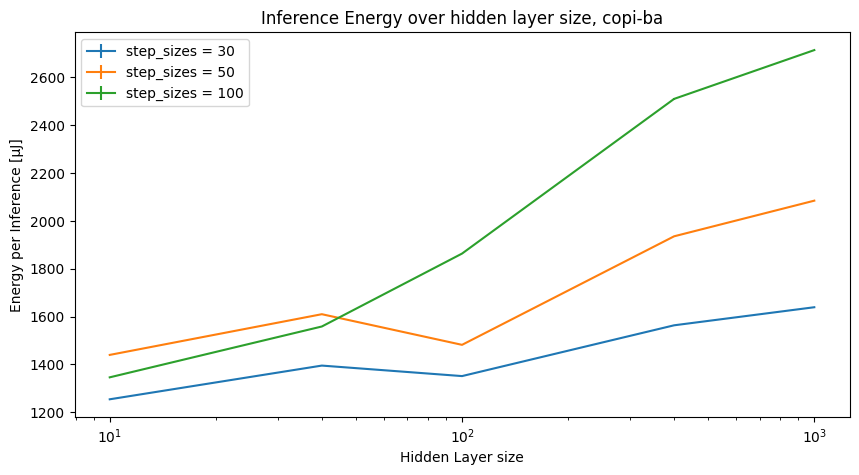

In [25]:
fig = plt.figure(figsize=(10,5))

for i in range(len(step_sizes)):
    plt.errorbar(layer_sizes, through_energy[:, i], yerr = through_energy_sd[:, i],
                label = f"step_sizes = {step_sizes[i]}")
    plt.xlabel("Hidden Layer size")
    plt.ylabel("Energy per Inference [µJ]")
    plt.title("Inference Energy over hidden layer size, copi-ba")
    plt.xscale('log')
    plt.legend()
    
fig.savefig('Inference_energy_dense_layer_stepsize_copi_ba.jpg', bbox_inches='tight', dpi=150)

plt.show()